# Imports

In [1]:
import enum
import itertools as it
import pickle
import typing
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shap
import strenum
import tqdm
import xgboost
from sklearn import (
    base,
    ensemble,
    feature_selection,
    metrics,
    model_selection,
    neighbors,
    preprocessing,
    svm,
)

/home/priyangshu/anaconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [2]:
class Models(strenum.StrEnum):
    SVM = enum.auto()
    XGB = enum.auto()
    RF = enum.auto()
    GB = enum.auto()
    AB = enum.auto()


class Rivers(strenum.StrEnum):
    BEAS = enum.auto()
    BRAHMAPUTRA = enum.auto()
    CAUVERY = enum.auto()
    GANGA = enum.auto()
    GODAVARI = enum.auto()
    KRISHNA = enum.auto()
    MAHANADI = enum.auto()
    SATLUJ = enum.auto()
    YAMUNA = enum.auto()


class Parameters(strenum.StrEnum):
    TEMP = "Temperature"
    DO = "Dissolved Oxygen"
    PH = "pH"
    COND = "Conductivity"
    BOD = "Biochemical Oxygen Demand"
    NC = "Nitrate Nitrite Conc"
    FC = "Fecal Coliform"
    TC = "Total Coliform"


long_keys = [lk.value for lk in Parameters]
short_keys = [lk.name for lk in Parameters]

short2long = {k: v for k, v in zip(short_keys, long_keys)}
long2short = {v: k for k, v in short2long.items()}

model_params: dict[
    Models,
    dict[
        typing.Literal["fixed", "tuning", "other"],
        dict[str, str | int | float | bool | list],
    ],
] = {
    Models.AB: {
        "fixed": {
            "loss": "square",
            "random_state": 0,
        },
        "tuning": {
            "n_estimators": [1000, 3000, 4500],
            "learning_rate": [0.001, 0.01, 0.1],
        },
        "other": {},
    },
    Models.GB: {
        "fixed": {
            "loss": "squared_error",
            "random_state": 0,
            "max_depth": 10,
            "subsample": 0.5,
        },
        "tuning": {
            "n_estimators": [1000, 3000, 4500],
            "learning_rate": [0.01, 0.001, 0.1],
        },
        "other": {},
    },
    Models.RF: {
        "fixed": {
            "max_depth": 10,
            "random_state": 0,
            "max_samples": 0.5,
            "criterion": "squared_error",
        },
        "tuning": {
            "n_estimators": [1000, 3000, 5000],
        },
        "other": {},
    },
    Models.XGB: {
        "fixed": {
            "random_state": 0,
            "subsample": 0.5,
        },
        "tuning": {
            "n_estimators": [5000, 7500, 10000, 15000, 20000],
            "learning_rate": [0.01, 0.1, 0.001],
        },
        "other": {
            "early_stopping_rounds": 50,
            "eval_metric": metrics.mean_squared_error,
        },
    },
    Models.SVM: {"fixed": {}, "tuning": {}, "other": {}},
}

estimators: dict[
    Models,
    type[ensemble.GradientBoostingRegressor]
    | type[ensemble.RandomForestRegressor]
    | type[svm.SVR]
    | type[xgboost.XGBRegressor]
    | type[ensemble.AdaBoostRegressor],
] = {
    Models.GB: ensemble.GradientBoostingRegressor,
    Models.RF: ensemble.RandomForestRegressor,
    Models.SVM: svm.SVR,
    Models.XGB: xgboost.XGBRegressor,
    Models.AB: ensemble.AdaBoostRegressor,
}

In [3]:
root_path = Path("./")
all_paths = {
    "model": root_path.joinpath("models"),
    "image": root_path.joinpath("images"),
    "best_param": root_path.joinpath("best_params"),
    "shap_value": root_path.joinpath("shap_values"),
    "data": root_path.joinpath("."),
}
for path in all_paths.values():
    path.mkdir(exist_ok=True, parents=True)

# Utils

In [4]:
T = typing.TypeVar("T")

In [5]:
def remove_outliers(data: pd.Series) -> list[int]:
    mu = data.mean()
    sigma = data.std()
    outliers_index = [
        i for i, x in enumerate(data) if x > (mu + 4 * sigma) or x < (mu - 4 * sigma)
    ]

    return outliers_index

In [6]:
def read_pkl(pkl_path: Path):
    with open(pkl_path, "rb") as pkl:
        return pickle.load(pkl)


def write_pkl(python_obj: any, pkl_path: Path):
    assert pkl_path.suffix == ".pkl", "Path does not point to a .pkl file."
    pkl_path.parent.mkdir(exist_ok=True, parents=True)

    with open(pkl_path, "wb") as pkl:
        return pickle.dump(python_obj, pkl, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
def file_exists(
    file_path_s: Path | list[Path] | typing.Iterator[Path],
) -> dict[typing.Literal["exists", "not_exists"], typing.List[Path]]:
    exists = []
    not_exists = []
    if isinstance(file_path_s, Path):
        return (
            {"exists": [file_path_s], "not_exists": []}
            if file_path_s.exists()
            else {"exists": [], "not_exists": [file_path_s]}
        )
        # return ([file_path_s], []) if file_path_s.exists() else ([], [file_path_s])
    for f_path in file_path_s:
        if f_path.exists():
            exists.append(f_path)
        else:
            not_exists.append(f_path)
    return {"exists": exists, "not_exists": not_exists}

In [8]:
def literal_to_list(abc: T) -> typing.List[T]:
    if abc is None:
        abc = []
    if not (isinstance(abc, enum.EnumType) or isinstance(abc, list)):
        return [abc]
    return abc

In [9]:
def concat_dicts(*args: dict[str, any]):
    return {k: v for k, v in it.chain(*[d.items() for d in args])}

In [10]:
def prettylog(prefix: str):
    return lambda x: print(f"[{prefix}]: {x}")

# Data Preparation

In [11]:
data_path = all_paths["data"].joinpath("WQ 2012_2021.csv")

In [12]:
def preprocess(data):
    df: pd.DataFrame = data.copy()
    df[df.columns] = preprocessing.MinMaxScaler().fit_transform(df)
    df = (df - df.mean()) / df.std()
    return df

In [47]:
df = pd.read_csv(data_path).dropna().filter(axis=1, like="AVG").reset_index(drop=True)
df[df.columns] = preprocessing.MinMaxScaler().fit_transform(df)
df.describe()
# ['DO_AVG'].sort_values().head(1800)

,T_AVG,DO_AVG,PH_AVG,COND_AVG,BOD_AVG,N_AVG,FC_AVG,TC_AVG
count,2350.000000,2350.000000,2350.000000,2350.000000,2350.000000,2350.000000,2.350000e+03,2350.000000
mean,0.230168,0.605028,0.648423,0.003321,0.046833,0.004533,2.082660e-03,0.002284
std,0.053441,0.129560,0.088871,0.022919,0.082901,0.021542,3.066044e-02,0.030271
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.210784,0.533898,0.586667,0.000788,0.016552,0.001206,8.201190e-07,0.000003
50%,0.240196,0.610169,0.653333,0.001167,0.027586,0.002413,5.679495e-06,0.000014
75%,0.264706,0.686441,0.706667,0.001995,0.045517,0.004580,5.259212e-05,0.000099
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000


In [ ]:
df = pd.read_csv(data_path).dropna().filter(axis=1, like="AVG").reset_index(drop=True)
# df[df.columns] = preprocessing.MinMaxScaler().fit_transform(df)
df.describe()
# ['DO_AVG'].sort_values().head(1800)

,T_AVG,DO_AVG,PH_AVG,COND_AVG,BOD_AVG,N_AVG,FC_AVG,TC_AVG
count,2350.000000,2350.000000,2350.000000,2350.000000,2350.000000,2350.000000,2.350000e+03,2.350000e+03
mean,23.477106,7.139330,7.781585,887.311617,3.395421,1.314964,1.145932e+05,1.829456e+05
std,5.451019,1.528802,0.333268,5882.379321,6.010342,6.249224,1.687014e+06,2.425137e+06
min,0.000000,0.000000,5.350000,35.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,21.500000,6.300000,7.550000,237.125000,1.200000,0.350000,4.512500e+01,2.656250e+02
50%,24.500000,7.200000,7.800000,334.500000,2.000000,0.700000,3.125000e+02,1.128250e+03
75%,27.000000,8.100000,8.000000,547.000000,3.300000,1.328750,2.893750e+03,7.952500e+03
max,102.000000,11.800000,9.100000,256690.000000,72.500000,290.100000,5.502250e+07,8.011500e+07


In [261]:
def clean_data(df, target):
    Q1 = df[target].quantile(0.25)
    Q3 = df[target].quantile(0.75)
    IQR = df[target].quantile([0.35, 0.65]).diff().dropna().iat[0]
    lower_fence = Q1 - 1.5 * IQR
    higher_fence = Q3 + 1.5 * IQR

    return df[(df[target] >= lower_fence) & (df[target] <= higher_fence)]

In [397]:
def get_data(target, exclude, split=0.2):
    df = pd.read_csv(data_path).dropna()
    if split < 0 or split > 1:
        return df
    train, test = model_selection.train_test_split(df, test_size=split, random_state=42)
    train: pd.DataFrame = train.filter(axis=1, like="AVG").reset_index(drop=True)
    test: pd.DataFrame = (
        test.drop(columns=["CODE", "LOCATION", "YEAR"])
        .groupby(["RIVER", "STATE"])
        .mean()
        .filter(axis=1, like="AVG")
    )
    train.columns = long_keys
    test.columns = long_keys
    exclude = literal_to_list(exclude)
    train = train.drop(columns=exclude)
    test = test.drop(columns=exclude)

    if target == None:
        return preprocess(test)

    return clean_data(preprocess(train), target), preprocess(test)

## Train Split

In [81]:
train_df = (
    pd.read_csv(data_path)
    .query("YEAR != 2021")
    .dropna()
    .filter(axis=1, like="AVG")
    .reset_index(drop=True)
)
train_df.columns = long_keys

outliers = []
for col in train_df.columns:
    outliers.extend(remove_outliers(train_df[col]))
train_df = train_df.drop(outliers).reset_index(drop=True)

train_df[long_keys] = preprocessing.MinMaxScaler().fit_transform(train_df)

## Test Split

In [183]:
test_df = (
    pd.read_csv(data_path)
    .dropna()
    .query("YEAR == 2021")
    .drop(columns=["CODE", "LOCATION", "YEAR"])
    .groupby(["RIVER", "STATE"])
    .mean()
    .filter(axis=1, like="AVG")
    # .reset_index(drop=True)
)
test_df.columns = long_keys
test_df[long_keys] = preprocessing.MinMaxScaler().fit_transform(test_df)

## Data fetch API

In [320]:
def get_train_data(
    df: pd.DataFrame,
    target: Parameters,
    validation_split: None | float | int = None,
):
    X = df.drop(columns=[target])
    y = df[target]

    if validation_split:
        assert 0 < validation_split < 1 or (
            isinstance(validation_split, int) and 0 < validation_split < 100
        ), "validation split must be between 0..1 or 0..100."
        return model_selection.train_test_split(
            X, y, test_size=validation_split, random_state=0
        )
    return X, y

In [321]:
def get_test_data(
    df: pd.DataFrame,
    target: Parameters,
):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

# Flags

In [322]:
OVERWRITE = {
    "best_params": False,
    "train_model": False,
    "img_generate": True,
    "shap_calculation": False,
}
# overwrite, ignoring and overwriting all cache.

# Model

## Finetuning Hyperparameters

In [375]:
def get_fineduned_hyperparams(
    model_name: Models,
    estimator: base.BaseEstimator,
    hyperparam: dict[str, typing.Any],
    sample_percent: float,
    train_df: dict[Parameters, pd.DataFrame],
    targets: Parameters | list[Parameters],
    path_prefix: Path = "",
) -> dict[Models, dict]:
    log = prettylog("Hyperparameter tuning")
    targets = literal_to_list(targets)

    if hyperparam.items().__len__() < 1:

        return {}.fromkeys(targets, {})

    best_model_params: dict[Models, dict] = {}

    processed = []
    if not OVERWRITE["best_params"]:
        log("Reading from cache...")
        for target in targets:
            best_param_PATH = all_paths["best_param"].joinpath(
                path_prefix, model_name, f"{target}.pkl"
            )
            if file_exists(best_param_PATH)["exists"].__len__() < 1:
                continue
            best_model_params[target] = read_pkl(best_param_PATH)
            processed.append(target)

    remaining_targets = set(targets) - set(processed)
    # print(targets)
    if len(remaining_targets) < 1:
        return best_model_params

    hp_tuner = model_selection.GridSearchCV(
        estimator=estimator, cv=5, n_jobs=5, verbose=0, param_grid=hyperparam
    )

    num_targets = len(remaining_targets)
    for index, target in (
        pbar := tqdm.tqdm(
            enumerate(remaining_targets),
            desc="Fine-tuing for",
            bar_format="{desc}",
        )
    ):
        param_find_df = (
            train_df[target].sample(frac=sample_percent).reset_index(drop=True)
        )
        pbar.set_description_str(
            f"Fine-tuning for {target}. Completed: ({index}/{num_targets})."
        )

        hp_tuner.fit(
            param_find_df.drop(columns=[target]),
            param_find_df[target],
        )
        best_model_params[target] = hp_tuner.best_params_
        write_pkl(
            python_obj=hp_tuner.best_params_,
            pkl_path=Path(
                all_paths["best_param"].joinpath(
                    path_prefix or "", model_name, f"{target}.pkl"
                ),
            ),
        )

        pbar.set_description_str(
            f"Fine-tuning for {target}. Completed: ({index+1}/{num_targets})."
        )

    return best_model_params

## to and from disk

In [376]:
def save_models(
    models_collection: dict[Models, dict[Parameters, base.BaseEstimator]],
    path_prefix: Path = "",
):
    for model_name, models_dict in models_collection.items():
        for target, model in models_dict.items():
            write_pkl(
                model,
                all_paths["model"]
                .joinpath(path_prefix, model_name, target)
                .with_suffix(".pkl"),
            )


def load_models(
    model_name: Models, targets: Parameters | list[Parameters], path_prefix: Path
):
    models: dict[Parameters, base.BaseEstimator] = {}
    targets = literal_to_list(targets)
    for target in targets:
        models[target] = read_pkl(
            pkl_path=all_paths["model"]
            .joinpath(path_prefix, model_name, target)
            .with_suffix(".pkl")
        )

    return models

## Train a single Model

In [377]:
def train(
    model_name: Models,
    targets: Parameters | list[Parameters],
    sample_percent: float,
    path_prefix: str,
    exclude_features: None | Parameters | list[Parameters] = None,
):
    log = prettylog("Training")
    models = {}

    exclude_features = literal_to_list(exclude_features)
    targets = literal_to_list(targets)

    if not OVERWRITE["train_model"]:
        cached_models_path, targets = file_exists(
            [
                all_paths["model"]
                .joinpath(path_prefix or "", model_name, target)
                .with_suffix(".pkl")
                for target in targets
            ]
        ).values()

        cached_models_path = [path.stem for path in cached_models_path]
        targets = [
            path.stem for path in targets if exclude_features.count(path.stem) < 1
        ]
        log("Reading from Cache...")
        models = load_models(model_name, cached_models_path, path_prefix)

    if models.__len__() > 0:
        return models

    assert 0 <= sample_percent <= 1, "Sample percent must be in 0..1"

    print(f"Training {model_name}")
    est = estimators[model_name]

    train_df = {}
    for target in targets:
        temp_df, _ = get_data(target, exclude=exclude_features)
        train_df[target] = temp_df

    finetuned = get_fineduned_hyperparams(
        model_name=model_name,
        estimator=est(**model_params[model_name]["fixed"]),
        hyperparam=model_params[model_name]["tuning"],
        sample_percent=sample_percent,
        train_df=train_df,
        targets=targets,
        path_prefix=path_prefix,
    )

    full_model_params = {}
    for target, finetuned_hp in finetuned.items():
        full_model_params[target] = concat_dicts(
            model_params[model_name]["fixed"],
            finetuned_hp,
            model_params[model_name]["other"],
        )

    num_targets = full_model_params.keys().__len__()
    for index, (target, parameters) in (
        pbar := tqdm.tqdm(
            enumerate(full_model_params.items()),
            desc="",
            bar_format="{desc}",
        )
    ):
        pbar.set_description_str(
            f"Training for {target}. Progress: {index + 1}/{num_targets}"
        )

        reg = est(**parameters)

        if model_name == Models.XGB:

            X_train, X_eval, y_train, y_eval = get_train_data(
                df=train_df[target],
                target=target,
                validation_split=0.2,
            )
            reg.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=0)
        else:
            X_train, y_train = get_train_data(df=train_df[target], target=target)
            reg.fit(X_train, y_train)

        models[target] = reg

    return models

## Train multiple Models

In [378]:
def train_models(
    exclude_features: None | Parameters | list[Parameters],
    include_models: tuple[bool, Models | list[Models]],
    sample_percent: float = 1,
    path_prefix: None | Path = None,
):
    if include_models[0]:
        model_names = set(literal_to_list(include_models[1]))
    else:
        model_names = set(Models).difference(set(literal_to_list(include_models[1])))

    exclude_features = literal_to_list(exclude_features)
    models = {}

    for model_name in model_names:
        models[model_name] = train(
            model_name,
            targets=list(set(Parameters) - set(exclude_features)),
            sample_percent=sample_percent,
            exclude_features=exclude_features,
            path_prefix=path_prefix,
        )

    if path_prefix:
        save_models(models, path_prefix)

## Train Model(s)

In [379]:
exclude_features = [Parameters.FC]
path_prefix = f"{'new/exclude_features/' if exclude_features.__len__() > 0 else 'new/optimized/'}{', '.join([long2short[omits] for omits in exclude_features])}"

In [380]:
OVERWRITE["train_model"] = False
OVERWRITE["best_params"] = False

models = train_models(
    exclude_features=exclude_features,
    include_models=(True, Models),
    path_prefix=path_prefix,
)

[Training]: Reading from Cache...
Training RF
[Hyperparameter tuning]: Reading from cache...


Training for Nitrate Nitrite Conc. Progress: 7/7     


[Training]: Reading from Cache...
Training GB
[Hyperparameter tuning]: Reading from cache...


Training for Nitrate Nitrite Conc. Progress: 7/7     


[Training]: Reading from Cache...
[Training]: Reading from Cache...
Training XGB
[Hyperparameter tuning]: Reading from cache...


Fine-tuning for Dissolved Oxygen. Completed: (7/7).         
Training for Dissolved Oxygen. Progress: 7/7         


[Training]: Reading from Cache...
Training AB
[Hyperparameter tuning]: Reading from cache...


Fine-tuning for Dissolved Oxygen. Completed: (7/7).         
Training for Dissolved Oxygen. Progress: 7/7         


## Testing Phase

In [381]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import linregress


def plot_metrics(y_actual, y_predict, title):
    r_squared = r2_score(y_actual, y_predict)
    rmse = np.sqrt(mean_squared_error(y_actual, y_predict))
    slope, intercept, _, _, _ = linregress(y_actual, y_predict)
    line = slope * y_actual + intercept

    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predict, color="blue", label="Actual vs. Predicted")
    plt.plot(
        y_actual,
        line,
        color="red",
        linestyle="-",
        linewidth=2,
        label="Linear Regression Line",
    )

    # Adding labels and legend
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    t = max(y_predict) - min(y_predict)
    plt.text(
        0.7,
        min(y_predict) + t * 0.1 + t * 0.1,
        f"R-squared: {r_squared:.2f}",
        fontsize=12,
    )
    plt.text(0.7, min(y_predict) + t * 0.1 + t * 0.2, f"RMSE: {rmse:.2f}", fontsize=12)
    plt.text(
        0.7, min(y_predict) + t * 0.1 + t * 0.3, f"Slope: {slope:.2f}", fontsize=12
    )
    plt.legend()

    plt.grid(True)
    plt.show()

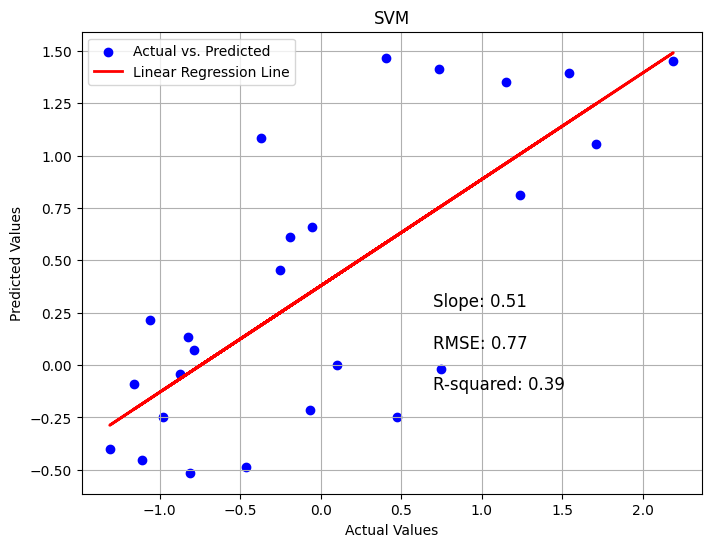

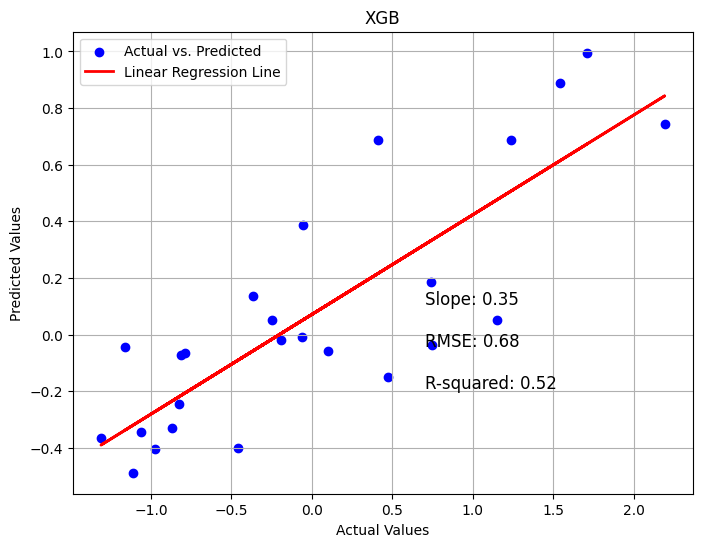

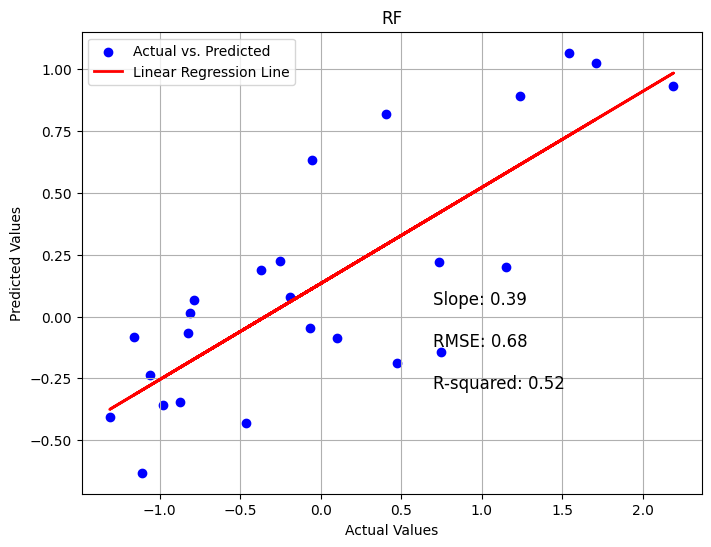

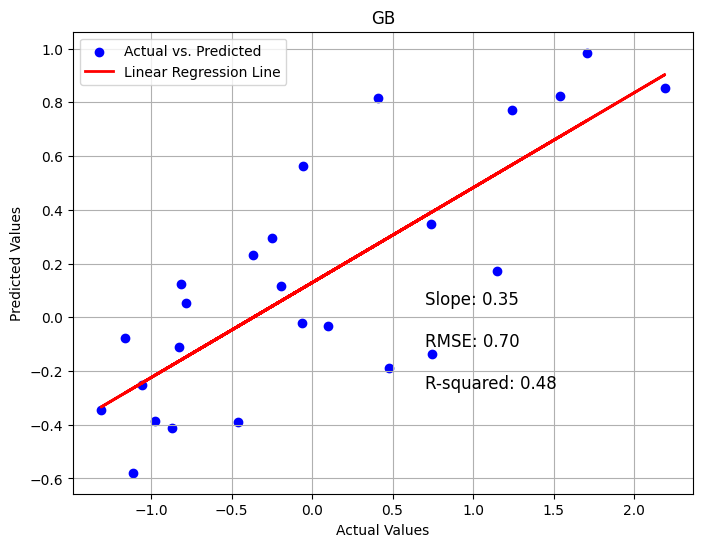

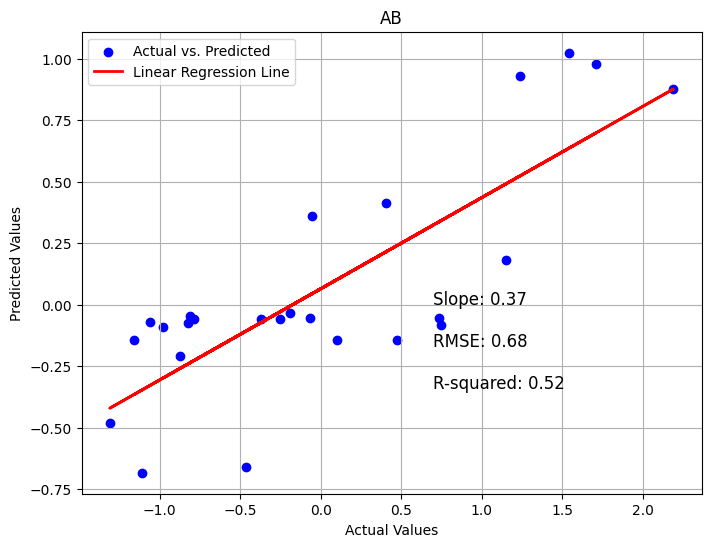

In [384]:
for model_n in Models:
    param = Parameters.DO
    model = read_pkl(
        pkl_path=all_paths["model"]
        .joinpath(path_prefix, model_n, param)
        .with_suffix(".pkl")
    )
    _, test_df = get_data(target=param, exclude=exclude_features)
    X_test, y_actual = get_test_data(df=test_df, target=param)
    y_predict = model.predict(X_test)

    plot_metrics(y_actual=y_actual, y_predict=y_predict, title=model_n)

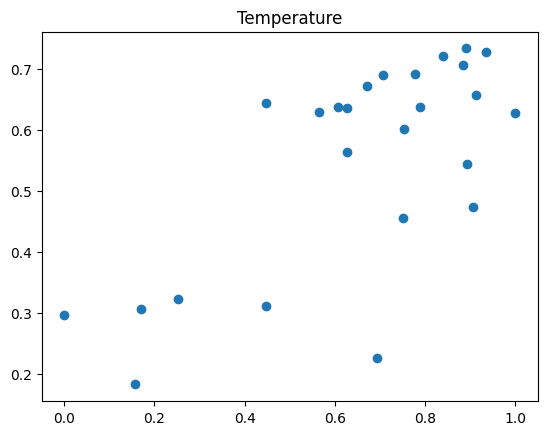

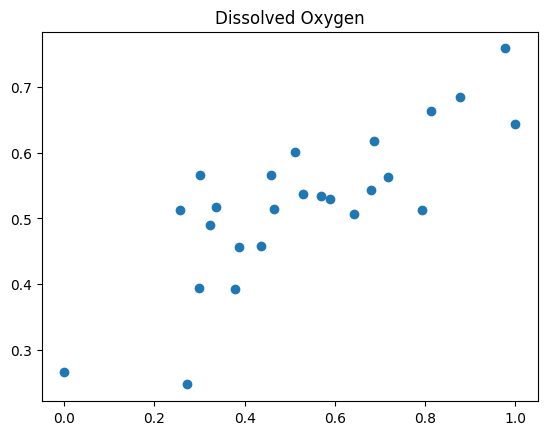

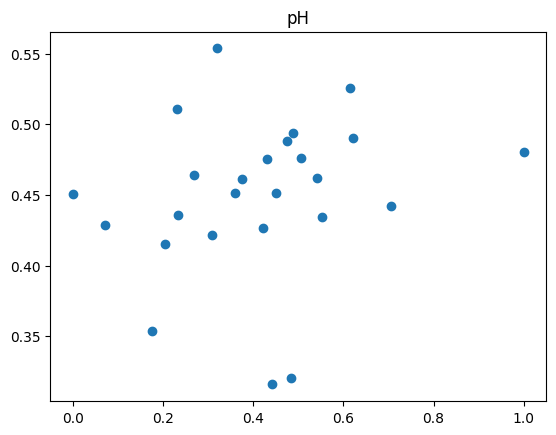

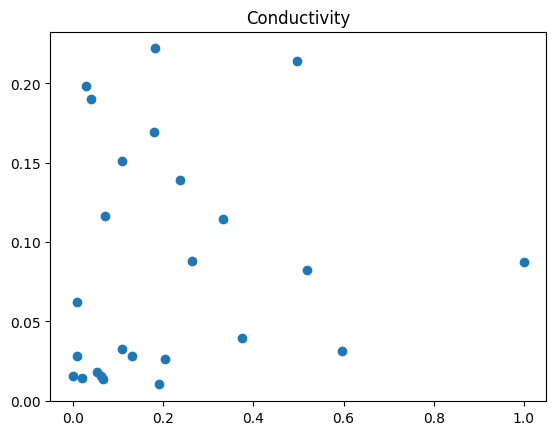

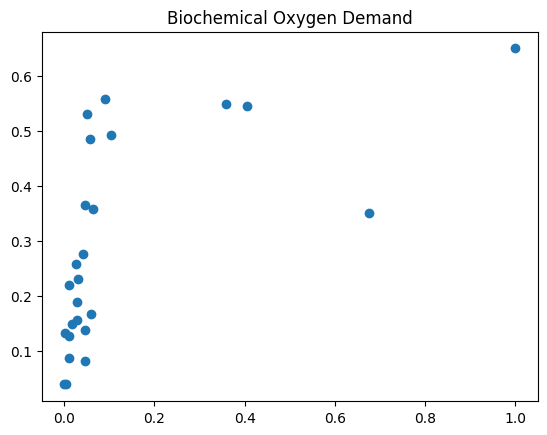

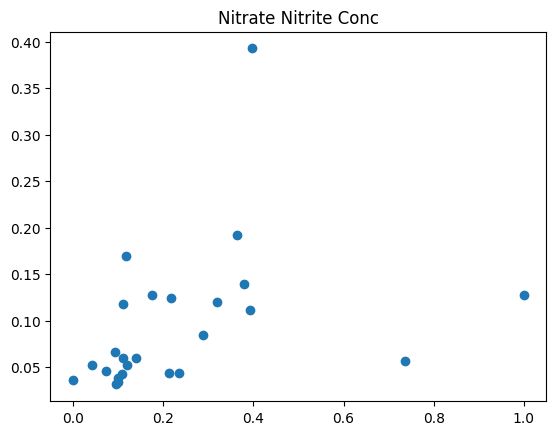

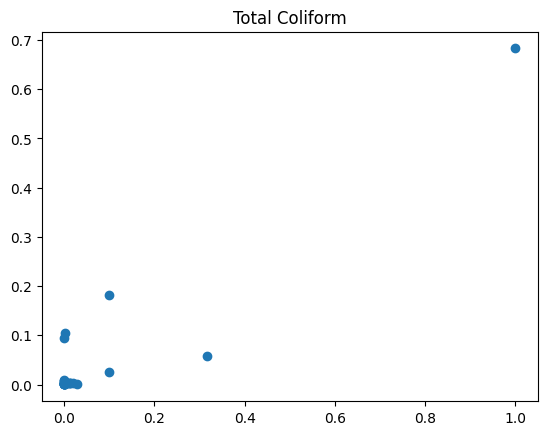

In [196]:
for param in Parameters:
    if param == Parameters.FC:
        continue
    model = read_pkl(
        pkl_path=all_paths["model"]
        .joinpath("exclude_features/FC", Models.RF, param)
        .with_suffix(".pkl")
    )
    X_test, y_test = get_test_data(
        df=test_df, target=param, exclude_features=Parameters.FC
    )
    y_predict = model.predict(X_test)
    plt.scatter(x=y_test, y=y_predict)
    plt.title(f"{param}")
    plt.show()

In [398]:
def test(
    test_df: pd.DataFrame, target: Parameters, model_path: Path
) -> dict[typing.Literal["mean_squared_error"], float]:
    X_test, y_test = get_test_data(df=test_df, target=target)
    model = read_pkl(pkl_path=model_path)
    y_predict = model.predict(X_test)
    return {
        "mean_squared_error": metrics.mean_squared_error(
            y_pred=y_predict, y_true=y_test
        )
    }

In [409]:
def riverToBestTarget(
    model_names: Models,
    path_prefix: str,
    exclude_features: list,
    rivers: Rivers | list[Rivers] = Rivers,
):
    model_river_error = {}
    test_df = get_data(target=None, exclude=exclude_features)
    for model_name in literal_to_list(model_names):
        river_error = {}
        rivers = literal_to_list(rivers)

        for river in rivers:
            df = test_df.filter(axis=0, like=river)
            error_dict = {}
            for target in filter(lambda x: exclude_features.count(x) < 1, Parameters):
                X, y_true = get_test_data(df=df, target=target)
                model = load_models(
                    model_name=model_name, targets=target, path_prefix=path_prefix
                )[target]
                y_pred = model.predict(X)
                error = metrics.mean_squared_error(y_pred=y_pred, y_true=y_true)
                error_dict[target.value] = error
            river_error[river.value] = {
                k: v for k, v in sorted(error_dict.items(), key=lambda item: item[1])
            }
        model_river_error[model_name.value] = river_error
    return model_river_error

In [410]:
model_river_error = riverToBestTarget(
    model_names=[Models.RF, Models.AB],
    path_prefix=path_prefix,
    exclude_features=Parameters.FC,
)

In [412]:
pd.DataFrame(
    {
        Models.AB: pd.DataFrame(model_river_error[Models.AB])
        .drop(index=[Parameters.TC])
        .idxmin(),
        Models.RF: pd.DataFrame(model_river_error[Models.RF])
        .drop(index=[Parameters.TC])
        .idxmin(),
    }
)

,AB,RF
BEAS,Biochemical Oxygen Demand,Biochemical Oxygen Demand
BRAHMAPUTRA,Dissolved Oxygen,Biochemical Oxygen Demand
CAUVERY,Biochemical Oxygen Demand,Biochemical Oxygen Demand
GANGA,Biochemical Oxygen Demand,Biochemical Oxygen Demand
GODAVARI,Biochemical Oxygen Demand,Biochemical Oxygen Demand
KRISHNA,Biochemical Oxygen Demand,Biochemical Oxygen Demand
MAHANADI,Biochemical Oxygen Demand,Biochemical Oxygen Demand
SATLUJ,Biochemical Oxygen Demand,Biochemical Oxygen Demand
YAMUNA,Dissolved Oxygen,Dissolved Oxygen


In [399]:
mse = {}
for target in Parameters:
    rse = {}
    if target == Parameters.FC.value:
        continue
    for model_name in Models:
        model_name = model_name.value
        test_df = get_data(None, exclude_features)
        rse[model_name] = test(
            test_df=test_df,
            model_path=all_paths["model"]
            .joinpath(path_prefix, model_name, target)
            .with_suffix(".pkl"),
            target=target,
        )["mean_squared_error"]
    mse[target.value] = rse

In [393]:
eval_df = pd.DataFrame(mse)
# eval_df['Total Error'] = eval_df.sum()
pd.DataFrame(
    dict(sorted(eval_df.sum().to_dict().items(), key=lambda item: item[1])),
    index=["error"],
).drop(columns=Parameters.TC)

,Dissolved Oxygen,Temperature,Biochemical Oxygen Demand,pH,Nitrate Nitrite Conc,Conductivity
error,2.469256,2.864556,4.464011,4.748881,4.777061,4.799477


In [ ]:
# S = (2 * a + (n-1) * d) * n / 2
# 1 = 6 * (6-1) * d / 2 => 2 = 30 * d => d = 2 / 30 = 1 / 15
# 1/15, 2/15, 3/15, 4/15, 5/15

In [400]:
# levels = [.5,.25,.125,.0625]
# levels = [0.4, 0.3, 0.2, 0.1]
n = 5
levels = [5 / 15, 4 / 15, 3 / 15, 2 / 15, 1 / 15]


def replace_conditional(row: pd.Series, selected_model):
    res = 0
    for lvl in range(n):
        if row.name == lvl:
            res += ((row == selected_model).astype(int) * levels[lvl]).sum()
    return res


compare_model = pd.DataFrame(
    {
        i: {
            col: pd.DataFrame(mse)[col].nsmallest(n).index[i]
            for col in long_keys
            if col != Parameters.FC.value
        }
        for i in range(n)
    }
)

rank_val = {}
for selected_model in Models:
    rank_val[selected_model.value] = (
        compare_model.transpose()
        .apply(lambda x: replace_conditional(x, selected_model), axis=1)
        .sum()
    )
rank = [
    (k, v) for k, v in sorted(rank_val.items(), key=lambda item: item[1], reverse=True)
]
rank

[('AB', 1.7999999999999998),
 ('RF', 1.6),
 ('SVM', 1.3333333333333333),
 ('GB', 1.2),
 ('XGB', 1.0666666666666667)]

In [401]:
pd.DataFrame(mse)
pd.DataFrame(rank)

,0,1
0,AB,1.800000
1,RF,1.600000
2,SVM,1.333333
3,GB,1.200000
4,XGB,1.066667


In [402]:
compare_model.transpose()

,Temperature,Dissolved Oxygen,pH,Conductivity,Biochemical Oxygen Demand,Nitrate Nitrite Conc,Total Coliform
0,SVM,AB,SVM,GB,AB,XGB,AB
1,AB,RF,AB,RF,SVM,GB,RF
2,RF,XGB,RF,XGB,RF,RF,SVM
3,XGB,GB,GB,AB,GB,AB,GB
4,GB,SVM,XGB,SVM,XGB,SVM,XGB


# XAI plots

## SHAP

In [439]:
def shap_func(config, train_df, only_values=False, save_plot=False):
    model_name = config["model_name"]
    path_prefix = config["path_prefix"]
    target = config["target"]

    print(model_name, target)
    assert (
        all_paths["model"].joinpath(path_prefix, model_name).exists()
    ), "Model not found."

    shap_PATH = (
        all_paths["shap_value"]
        .joinpath(path_prefix, model_name, target)
        .with_suffix(".pkl")
    )

    shap_EXIST, _ = file_exists(shap_PATH).values()
    if shap_EXIST.__len__() > 0 and shap_EXIST[0].is_dir():
        shap_EXIST[0].rmdir()
        shap_EXIST = []

    shap_value = None
    if not OVERWRITE["shap_calculation"] and shap_EXIST.__len__() > 0:
        shap_value = read_pkl(shap_PATH)

    shap_PATH.parent.mkdir(exist_ok=True, parents=True)

    X_train, *_ = get_train_data(
        df=train_df,
        target=target,
        validation_split=0.2 if model_name == Models.XGB else None,
    )

    # X_train, *_ = get_train_data(
    #     df=train_df, target=target
    # )
    # X_train.columns = list(map(lambda x: long2short[x], X_train.columns))

    model = load_models(model_name, target, path_prefix)[target]

    explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 100))
    if shap_value is None:
        shap_value = explainer(X_train)
        write_pkl(
            shap_value,
            all_paths["shap_value"]
            .joinpath(path_prefix, model_name, target)
            .with_suffix(".pkl"),
        )

    def save_plot(type: typing.Literal["bar", "summary", "beeswarm"]):
        image_path = (
            all_paths["image"]
            .joinpath(type, path_prefix, model_name, target)
            .with_suffix(".jpg")
        )
        image_path.parent.mkdir(exist_ok=True, parents=True)
        plt.savefig(image_path, bbox_inches="tight")

    if not only_values and OVERWRITE["img_generate"]:
        plt.title(target)
        shap.summary_plot(
            shap_value,
            X_train,
            alpha=0.4,
            show=not save_plot,
        )
        if save_plot:
            save_plot("summary")
        plt.show()

        plt.title(target)
        shap.summary_plot(shap_value, X_train, plot_type="violin", show=not save_plot)
        if save_plot:
            save_plot("violin")
        plt.show()

        plt.title(target)
        shap.plots.bar(shap_value, show=not save_plot)
        if save_plot:
            save_plot("bar")
        plt.show()

        force_plot = shap.force_plot(
            explainer.expected_value, shap_value.values, X_train
        )
        html_path = (
            all_paths["image"]
            .joinpath("force", path_prefix, model_name, target)
            .with_suffix(".html")
        )
        html_path.parent.mkdir(exist_ok=True, parents=True)
        shap.save_html(html_path.__str__(), force_plot)

    return shap_value

AB Temperature


100%|██████████| 1457/1457 [1:11:26<00:00,  2.94s/it]


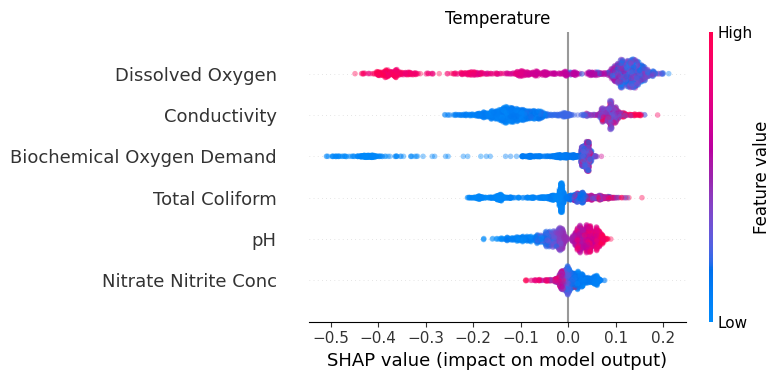

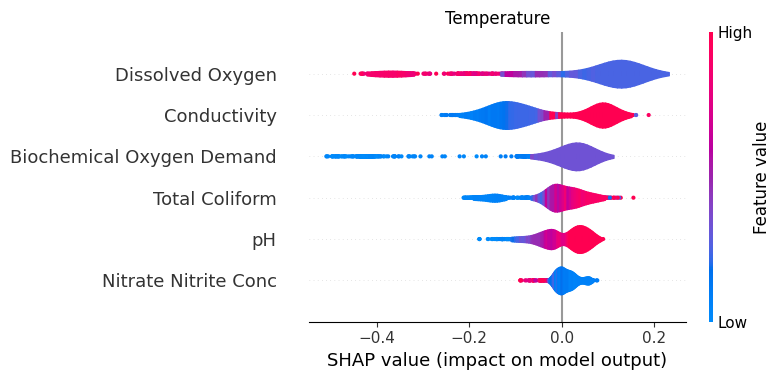

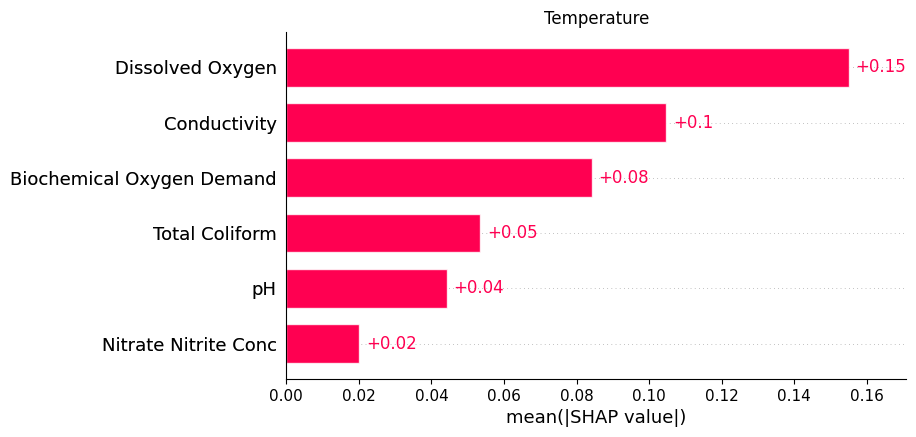

AB Dissolved Oxygen


100%|██████████| 1457/1457 [1:07:10<00:00,  2.77s/it]


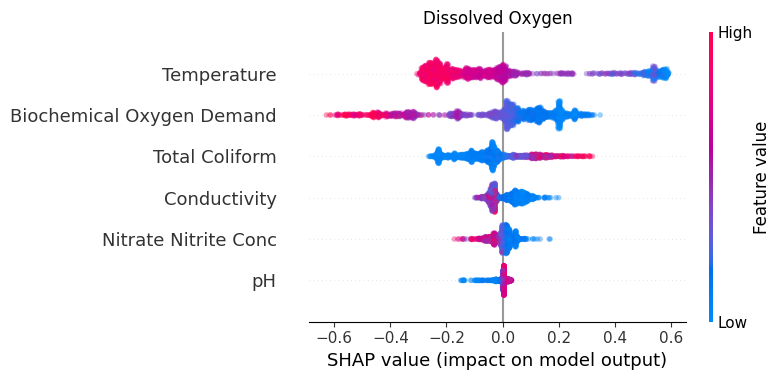

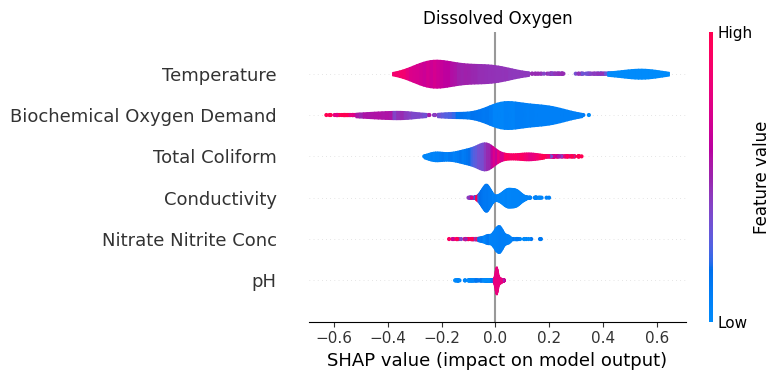

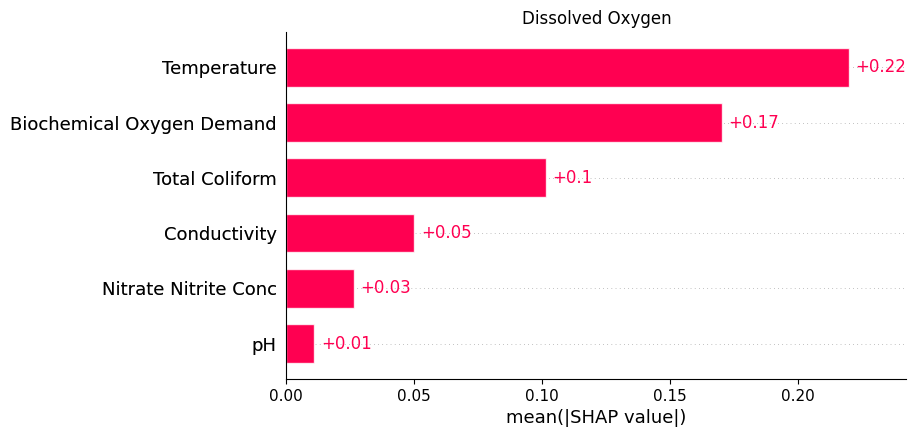

KeyboardInterrupt: 

In [440]:
# for model_name in Models:
#     if model_name is Models.SVM:
#         continue
model_name = Models.AB
for target_name in Parameters:
    if target_name is Parameters.FC:
        continue
    train_df, _ = get_data(target, exclude=exclude_features)
    shap_func(
        config={
            "model_name": model_name,
            "target": target_name,
            "path_prefix": path_prefix,
        },
        train_df=train_df,
        save_plot=True,
    )

In [170]:
model_name = Models.RF
target = Parameters.TC

In [171]:
targets = target
log = prettylog("Training")
models = {}

exclude_features = literal_to_list(exclude_features)
targets = literal_to_list(targets)
est = estimators[model_name]

finetuned = get_fineduned_hyperparams(
    model_name=model_name,
    estimator=est(**model_params[model_name]["fixed"]),
    hyperparam=model_params[model_name]["tuning"],
    sample_percent=1,
    train_df=train_df,
    targets=targets,
    exclude_features=exclude_features,
    path_prefix=path_prefix,
)

full_model_params = {}
for target, finetuned_hp in finetuned.items():
    full_model_params[target] = concat_dicts(
        model_params[model_name]["fixed"],
        finetuned_hp,
        model_params[model_name]["other"],
    )

num_targets = full_model_params.keys().__len__()
for index, (target, parameters) in (
    pbar := tqdm.tqdm(
        enumerate(full_model_params.items()),
        desc="",
        bar_format="{desc}",
    )
):
    pbar.set_description_str(
        f"Training for {target}. Progress: {index + 1}/{num_targets}"
    )

    reg = est(**parameters)

    if model_name == Models.XGB:
        X_train, X_eval, y_train, y_eval = get_train_data(
            df=train_df,
            target=target,
            validation_split=0.2,
            exclude_features=exclude_features,
        )
        reg.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=0)
    else:
        X_train, y_train = get_train_data(
            df=train_df, target=target, exclude_features=exclude_features
        )
        reg.fit(X_train, y_train)

    models[target] = reg

[Hyperparameter tuning]: Reading from cache...
[<Parameters.TC: 'Total Coliform'>]


Training for Total Coliform. Progress: 1/1


In [172]:
models[target]

RandomForestRegressor(max_depth=10, max_samples=0.5, n_estimators=1000,
                      random_state=0)

In [173]:
X_train, *_ = get_train_data(
    df=train_df,
    target=target,
    # validation_split=0.2 if model_name == Models.XGB else None,
    exclude_features=exclude_features,
)
# model = load_models(model_name, target, path_prefix)[target]
model = models[target]

explainer = shap.TreeExplainer(model, X_train)
shap_value = explainer(X_train, check_additivity=False)

 99%|===================| 1951/1963 [02:00<00:00]        

In [174]:
write_pkl(
    shap_value,
    all_paths["shap_value"]
    .joinpath(path_prefix, model_name, target)
    .with_suffix(".pkl"),
)